In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import pandas as pd

# ---------------------------
# Problem Parameters
# ---------------------------
TOTAL_DAYS_UNTIL_FLIGHT = 365  # days until flight
COACH_SEAT_CAPACITY = 100
FIRST_CLASS_SEAT_CAPACITY = 20

# Show-up probabilities at flight day
COACH_PASSENGER_SHOW_PROBABILITY = 0.95
FIRST_CLASS_PASSENGER_SHOW_PROBABILITY = 0.97

# Ticket prices and base sale probabilities
# Coach: if price $300 then 65%, if price $350 then 30%
COACH_TICKET_PRICES = [300, 350]
COACH_TICKET_SALE_PROBABILITIES = [0.65, 0.30]
# When first-class is sold out, the chance increases by 0.03 (i.e. 3 percentage points)
COACH_TICKET_SALE_BONUS = 0.03

# First-class: if price $425 then 8%, if price $500 then 4%
FIRST_CLASS_TICKET_PRICES = [425, 500]
FIRST_CLASS_TICKET_SALE_PROBABILITIES = [0.08, 0.04]

# Discount factor: 17% per year -> daily discount factor:
DAILY_DISCOUNT_RATE = 1 / (1 + 0.17 / 365)

# Overbooking costs for coach:
BUMP_TO_FIRST_CLASS_COMPENSATION = 50    # cost to bump a coach passenger to first-class
BUMP_OFF_COMPENSATION = 425   # cost to bump a coach passenger off the flight


# ---------------------------
# Terminal Overbooking Cost Function
# ---------------------------
def calculate_terminal_overbooking_cost(remaining_coach_seats, remaining_first_class_seats, allowed_coach_tickets, allowed_first_class_tickets):
    """
    At terminal day t = T, no more ticket revenue is generated.
    The tickets sold are:
       coach_tickets_sold = allowed_coach_tickets - remaining_coach_seats
       first_class_tickets_sold = allowed_first_class_tickets - remaining_first_class_seats
    At flight day, each ticket holder shows up with a given probability.
    For coach, if more passengers show up than actual coach seats (COACH_SEAT_CAPACITY),
    then up to available first-class seats (if not filled by first-class passengers) can be used 
    (at cost BUMP_TO_FIRST_CLASS_COMPENSATION), and any extra passenger is bumped off (at cost BUMP_OFF_COMPENSATION).
    The expected cost is computed using the binomial probabilities.
    """
    coach_tickets_sold = allowed_coach_tickets - remaining_coach_seats
    first_class_tickets_sold = allowed_first_class_tickets - remaining_first_class_seats
    
    expected_terminal_cost = 0.0
    # For first-class, sales are limited by capacity so first_class_tickets_sold is always <= FIRST_CLASS_SEAT_CAPACITY.
    # But show-ups are stochastic.
    for first_class_show_count in range(first_class_tickets_sold + 1):  # possible number of first-class passengers who show up
        first_class_show_probability = binom.pmf(first_class_show_count, first_class_tickets_sold, FIRST_CLASS_PASSENGER_SHOW_PROBABILITY)
        # available first-class seats to reassign from coach no-shows:
        spare_first_class_seats = max(FIRST_CLASS_SEAT_CAPACITY - first_class_show_count, 0)
        for coach_show_count in range(coach_tickets_sold + 1):
            coach_show_probability = binom.pmf(coach_show_count, coach_tickets_sold, COACH_PASSENGER_SHOW_PROBABILITY)
            # if coach show-ups exceed coach_seats, then extra passengers need bumping
            extra_passengers = max(coach_show_count - COACH_SEAT_CAPACITY, 0)
            # Of the extra, up to spare_first_class_seats can be reallocated (bumped to first-class) at lower cost.
            bump_to_first_class_count = min(extra_passengers, spare_first_class_seats)
            bumped_off_count = extra_passengers - bump_to_first_class_count
            terminal_cost = bump_to_first_class_count * BUMP_TO_FIRST_CLASS_COMPENSATION + bumped_off_count * BUMP_OFF_COMPENSATION
            expected_terminal_cost += first_class_show_probability * coach_show_probability * terminal_cost
    return expected_terminal_cost

# ---------------------------
# Dynamic Programming Routine
# ---------------------------
def solve_dynamic_programming(overbooking_allowance=None, allow_no_sale=False, use_seasonality=False):
    """
    If allow_no_sale is False, we use the previous policy with a hard cap:
         allowed_coach = COACH_SEAT_CAPACITY + overbooking_allowance.
    If allow_no_sale is True and an overbooking_allowance is provided, we use:
         allowed_coach = COACH_SEAT_CAPACITY + overbooking_allowance,
    otherwise (if overbooking_allowance is None) we set allowed_coach = 120 (the maximum coach tickets).
    
    The new flag, use_seasonality, when True multiplies the sale probabilities on day t by:
         0.75 + t/730.
    In both cases, allowed_fc remains FIRST_CLASS_SEAT_CAPACITY.
    """

    allowed_coach_tickets = COACH_SEAT_CAPACITY + overbooking_allowance
    allowed_first_class_tickets = FIRST_CLASS_SEAT_CAPACITY

    # State space for remaining tickets.
    coach_seat_state_values = np.arange(allowed_coach_tickets + 1)
    first_class_seat_state_values = np.arange(allowed_first_class_tickets + 1)

    value_matrix = np.zeros((allowed_coach_tickets+1, allowed_first_class_tickets+1, TOTAL_DAYS_UNTIL_FLIGHT+1))
    policy_matrix = np.empty((allowed_coach_tickets+1, allowed_first_class_tickets+1, TOTAL_DAYS_UNTIL_FLIGHT), dtype=object)

    # Terminal condition: at t = T, no more revenue; incur overbooking costs.
    for coach_seat_index, coach_seats_remaining in enumerate(coach_seat_state_values):
        for first_class_seat_index, first_class_seats_remaining in enumerate(first_class_seat_state_values):
            value_matrix[coach_seat_index, first_class_seat_index, TOTAL_DAYS_UNTIL_FLIGHT] = - calculate_terminal_overbooking_cost(coach_seats_remaining, first_class_seats_remaining, allowed_coach_tickets, allowed_first_class_tickets)

    # Determine coach decision options.
    if allow_no_sale:
        coach_decision_options = [0, 1, 2]  # 0: low price, 1: high price, 2: force no sale
    else:
        coach_decision_options = [0, 1]

    # Backward induction: iterate from t = T-1 down to 0.
    for current_day in range(TOTAL_DAYS_UNTIL_FLIGHT-1, -1, -1):
        # Compute the seasonality multiplier if desired.
        if use_seasonality:
            seasonality_factor = 0.75 + current_day/730
        else:
            seasonality_factor = 1.0

        for coach_seat_index, coach_seats_remaining in enumerate(coach_seat_state_values):
            for first_class_seat_index, first_class_seats_remaining in enumerate(first_class_seat_state_values):
                best_value = -np.inf
                best_decision = None

                for coach_decision in coach_decision_options:
                    for first_class_decision in [0, 1]:
                        # For first-class: if no fc tickets remain, no sale.
                        if first_class_seat_index == 0:
                            first_class_sale_probability = 0.0
                        else:
                            first_class_sale_probability = FIRST_CLASS_TICKET_SALE_PROBABILITIES[first_class_decision] * seasonality_factor
                            first_class_sale_probability = min(first_class_sale_probability, 1.0)  # ensure probability does not exceed 1

                        # For coach: if no sale option is chosen, force p_coach to 0.
                        if allow_no_sale and coach_decision == 2:
                            coach_sale_probability = 0.0
                        else:
                            if coach_seats_remaining == 0:
                                coach_sale_probability = 0.0
                            else:
                                if first_class_seat_index == 0:
                                    # When fc is sold out, bonus applies.
                                    coach_sale_probability = min((COACH_TICKET_SALE_PROBABILITIES[coach_decision] + COACH_TICKET_SALE_BONUS) * seasonality_factor, 1.0)
                                else:
                                    coach_sale_probability = min(COACH_TICKET_SALE_PROBABILITIES[coach_decision] * seasonality_factor, 1.0)

                        # Immediate revenue from sales on day t.
                        current_day_revenue = 0.0
                        if first_class_seats_remaining > 0:
                            current_day_revenue += first_class_sale_probability * FIRST_CLASS_TICKET_PRICES[first_class_decision]
                        if coach_seats_remaining > 0 and not (allow_no_sale and coach_decision == 2):
                            current_day_revenue += coach_sale_probability * COACH_TICKET_PRICES[coach_decision]

                        # Expected future value from state transitions:
                        expected_future_value = 0.0
                        # Outcome 1: no sale for both classes.
                        expected_future_value += (1 - first_class_sale_probability) * (1 - coach_sale_probability) * value_matrix[coach_seat_index, first_class_seat_index, current_day+1]
                        # Outcome 2: fc sale only.
                        if first_class_seat_index > 0:
                            expected_future_value += first_class_sale_probability * (1 - coach_sale_probability) * value_matrix[coach_seat_index, first_class_seat_index-1, current_day+1]
                        # Outcome 3: coach sale only.
                        if coach_seats_remaining > 0:
                            expected_future_value += (1 - first_class_sale_probability) * coach_sale_probability * value_matrix[coach_seat_index-1, first_class_seat_index, current_day+1]
                        # Outcome 4: both sales occur.
                        if (coach_seats_remaining > 0) and (first_class_seat_index > 0):
                            expected_future_value += first_class_sale_probability * coach_sale_probability * value_matrix[coach_seat_index-1, first_class_seat_index-1, current_day+1]

                        total_value = current_day_revenue + DAILY_DISCOUNT_RATE * expected_future_value

                        if total_value > best_value:
                            best_value = total_value
                            best_decision = (coach_decision, first_class_decision)
                value_matrix[coach_seat_index, first_class_seat_index, current_day] = best_value
                policy_matrix[coach_seat_index, first_class_seat_index, current_day] = best_decision

    return value_matrix, policy_matrix, value_matrix[allowed_coach_tickets, allowed_first_class_tickets, 0]

def simulate_policy(policy_matrix, allowed_coach_tickets, allowed_first_class_tickets, total_days, daily_discount_rate, num_simulations=1000, allow_no_sale=False, use_seasonality=False):
    """
    Simulate the forward process using the given DP policy.
    
    For each simulation run we track:
      - Total discounted profit
      - Number of coach and FC tickets sold
      - Actual show-ups (simulated via binomial draws)
      - Number of passengers bumped (if coach is overbooked)
      - Terminal overbooking cost
      - A flag indicating whether the coach was overbooked
      
    Returns a list of dictionaries, one per simulation run.
    """
    simulation_results = []
    for simulation in range(num_simulations):
        
        remaining_coach_seats = allowed_coach_tickets
        remaining_first_class_seats = allowed_first_class_tickets
        current_discount = 1.0
        total_profit = 0.0
        
        # Simulate day-by-day ticket sales (from t=0 to T-1)
        for current_day in range(total_days):
            if use_seasonality:
                seasonality_factor = 0.75 + current_day/730
            else:
                seasonality_factor = 1.0

            # Get optimal decision from the policy for the current state and day.
            decision = policy_matrix[remaining_coach_seats, remaining_first_class_seats, current_day]  # (coach_decision, first_class_decision)
            coach_decision, first_class_decision = decision

            # Compute first-class sale probability.
            if remaining_first_class_seats > 0:
                first_class_sale_probability = FIRST_CLASS_TICKET_SALE_PROBABILITIES[first_class_decision] * seasonality_factor
                first_class_sale_probability = min(first_class_sale_probability, 1.0)
            else:
                first_class_sale_probability = 0.0

            # Compute coach sale probability.
            if allow_no_sale and coach_decision == 2:
                coach_sale_probability = 0.0
            else:
                if remaining_coach_seats > 0:
                    if remaining_first_class_seats == 0:
                        coach_sale_probability = min((COACH_TICKET_SALE_PROBABILITIES[coach_decision] + COACH_TICKET_SALE_BONUS) * seasonality_factor, 1.0)
                    else:
                        coach_sale_probability = min(COACH_TICKET_SALE_PROBABILITIES[coach_decision] * seasonality_factor, 1.0)
                else:
                    coach_sale_probability = 0.0

            # Simulate sale outcomes as independent Bernoulli trials.
            first_class_sale = (remaining_first_class_seats > 0) and (np.random.rand() < first_class_sale_probability)
            coach_sale = (remaining_coach_seats > 0) and (np.random.rand() < coach_sale_probability)

            current_day_revenue = 0.0
            if first_class_sale:
                current_day_revenue += FIRST_CLASS_TICKET_PRICES[first_class_decision]
                remaining_first_class_seats -= 1
            if coach_sale and not (allow_no_sale and coach_decision == 2):
                current_day_revenue += COACH_TICKET_PRICES[coach_decision]
                remaining_coach_seats -= 1

            total_profit += current_discount * current_day_revenue
            current_discount *= daily_discount_rate

        # End-of-horizon: simulate actual show-ups and compute terminal overbooking cost.
        coach_tickets_sold = allowed_coach_tickets - remaining_coach_seats
        first_class_tickets_sold = allowed_first_class_tickets - remaining_first_class_seats
        first_class_show_count = np.random.binomial(n=first_class_tickets_sold, p=FIRST_CLASS_PASSENGER_SHOW_PROBABILITY) if first_class_tickets_sold > 0 else 0
        coach_show_count = np.random.binomial(n=coach_tickets_sold, p=COACH_PASSENGER_SHOW_PROBABILITY) if coach_tickets_sold > 0 else 0

        extra_passengers = max(coach_show_count - COACH_SEAT_CAPACITY, 0)
        spare_first_class_seats = max(FIRST_CLASS_SEAT_CAPACITY - first_class_show_count, 0)
        bump_to_first_class_count = min(extra_passengers, spare_first_class_seats)
        bumped_off_count = extra_passengers - bump_to_first_class_count
        terminal_cost_run = bump_to_first_class_count * BUMP_TO_FIRST_CLASS_COMPENSATION + bumped_off_count * BUMP_OFF_COMPENSATION

        total_profit += current_discount * (-terminal_cost_run)

        simulation_results.append({
            "total_profit": total_profit,
            "coach_sold": coach_tickets_sold,
            "fc_sold": first_class_tickets_sold,
            "coach_show": coach_show_count,
            "fc_show": first_class_show_count,
            "bumped_off": bumped_off_count,
            "bump_to_fc": bump_to_first_class_count,
            "terminal_cost": terminal_cost_run,
            "overbooked": (coach_show_count > COACH_SEAT_CAPACITY)
        })
    return simulation_results



PART 1
Solving DP for fixed coach overbooking = 5
  Expected discounted profit with 5 overbooking: $41886.16

PART 2
Solving DP for coach overbooking = 6
  Expected discounted profit: $42011.22
Solving DP for coach overbooking = 7
  Expected discounted profit: $42085.54
Solving DP for coach overbooking = 8
  Expected discounted profit: $42122.17
Solving DP for coach overbooking = 9
  Expected discounted profit: $42134.62
Solving DP for coach overbooking = 10
  Expected discounted profit: $42132.90
Solving DP for coach overbooking = 11
  Expected discounted profit: $42123.67
Solving DP for coach overbooking = 12
  Expected discounted profit: $42111.03
Solving DP for coach overbooking = 13
  Expected discounted profit: $42097.42
Solving DP for coach overbooking = 14
  Expected discounted profit: $42084.11
Solving DP for coach overbooking = 15
  Expected discounted profit: $42071.74

Best overbooking policy: Overbook coach by 9 seats with expected profit of $42134.62


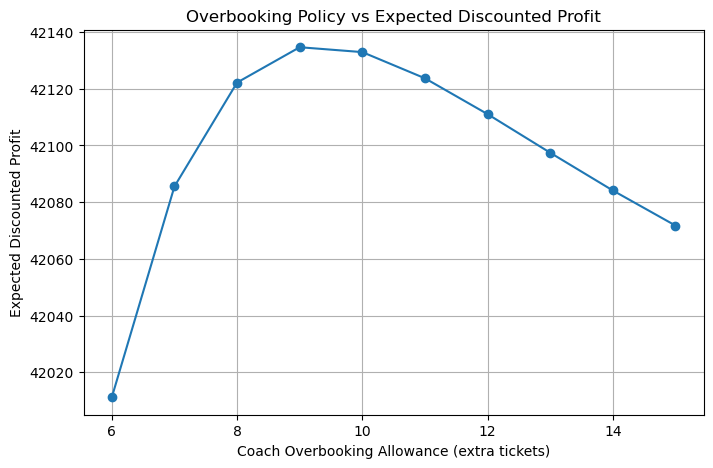

In [2]:

# ---------------------------
# 1) Evaluate Fixed Overbooking Policy (5 extra seats)
# ---------------------------
print("PART 1")
print("Solving DP for fixed coach overbooking = 5")
value_matrix_fixed, policy_matrix_fixed, profit_fixed = solve_dynamic_programming(5)
print("  Expected discounted profit with 5 overbooking: ${:.2f}".format(profit_fixed))

# ---------------------------
# 2) Evaluate Different Overbooking Policies (from 6 to 15 extra seats)
# ---------------------------
print('\nPART 2')
overbooking_values = np.arange(6, 16)  # from 6 to 15 extra seats in coach
profits = []

for overbook_amount in overbooking_values:
    print("Solving DP for coach overbooking =", overbook_amount)
    value_matrix, policy_matrix, profit = solve_dynamic_programming(overbook_amount)
    profits.append(profit)
    print("  Expected discounted profit: ${:.2f}".format(profit))

# Find the best overbooking level from Part 2.
best_index = np.argmax(profits)
best_overbooking = overbooking_values[best_index]
print("\nBest overbooking policy: Overbook coach by", best_overbooking, 
      "seats with expected profit of ${:.2f}".format(profits[best_index]))

# Plot results from Part 2.
plt.figure(figsize=(8,5))
plt.plot(overbooking_values, profits, marker='o')
plt.xlabel("Coach Overbooking Allowance (extra tickets)")
plt.ylabel("Expected Discounted Profit")
plt.title("Overbooking Policy vs Expected Discounted Profit")
plt.grid(True)
plt.show()



PART 3
Solving DP for new policy with no sale option (max 120 coach seats)
Evaluating Fixed Overbooking Policies (no 'no sale' option):
  Overbooking =  0 extra seats, Expected discounted profit: $  40654.29
  Overbooking =  1 extra seats, Expected discounted profit: $  40942.07
  Overbooking =  2 extra seats, Expected discounted profit: $  41221.45
  Overbooking =  3 extra seats, Expected discounted profit: $  41481.58
  Overbooking =  4 extra seats, Expected discounted profit: $  41707.62
  Overbooking =  5 extra seats, Expected discounted profit: $  41886.16
  Overbooking =  6 extra seats, Expected discounted profit: $  42011.22
  Overbooking =  7 extra seats, Expected discounted profit: $  42085.54
  Overbooking =  8 extra seats, Expected discounted profit: $  42122.17
  Overbooking =  9 extra seats, Expected discounted profit: $  42134.62
  Overbooking = 10 extra seats, Expected discounted profit: $  42138.14
  Overbooking = 11 extra seats, Expected discounted profit: $  42139.33

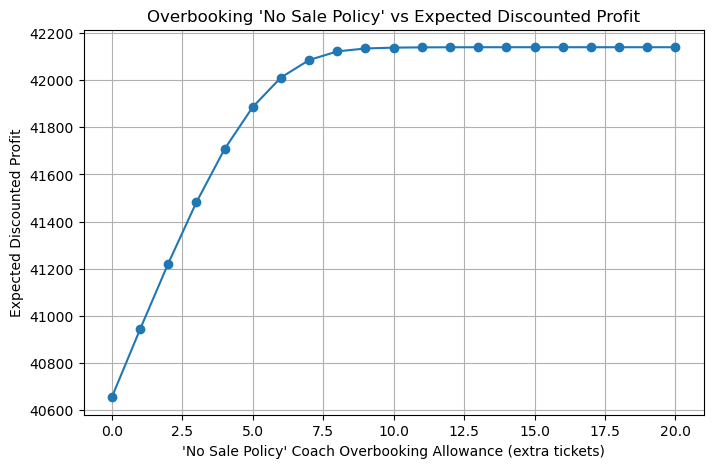


Comparison:
  The 'no sale' option policy performs BETTER by $11.00

PART 4
Solving DP with seasonality factor (demand increases as departure nears)
Evaluating Fixed Overbooking Policies (no 'no sale' option):
  Overbooking =  0 extra seats, Expected discounted profit: $  40350.75
  Overbooking =  1 extra seats, Expected discounted profit: $  40637.99
  Overbooking =  2 extra seats, Expected discounted profit: $  40916.93
  Overbooking =  3 extra seats, Expected discounted profit: $  41176.67
  Overbooking =  4 extra seats, Expected discounted profit: $  41402.35
  Overbooking =  5 extra seats, Expected discounted profit: $  41580.54
  Overbooking =  6 extra seats, Expected discounted profit: $  41704.54
  Overbooking =  7 extra seats, Expected discounted profit: $  41777.15
  Overbooking =  8 extra seats, Expected discounted profit: $  41812.89
  Overbooking =  9 extra seats, Expected discounted profit: $  41825.07
  Overbooking = 10 extra seats, Expected discounted profit: $  41823.

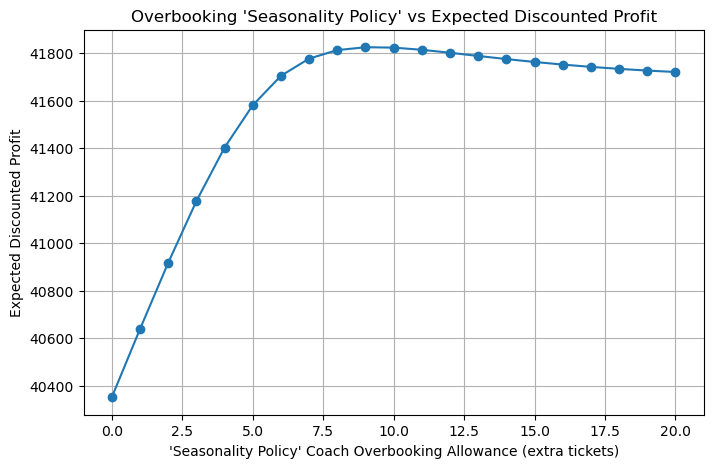


Comparison:
'No Sale' policy performs BETTER by $314.82

PART 5
Summary for Policy A (No Sale Option):
Mean Total Profit: 42150.75
Profit Volatility (Std): 959.22
Overbook Frequency: 83.70%
Average Number Bumped Off: 2.30
Average Terminal Cost: 1020.02
Average Coach Tickets Sold: 108.36
Average FC Tickets Sold: 19.59
Average Coach Show-ups: 102.98
Average FC Show-ups: 18.99


Summary for Policy B (Seasonality):
Mean Total Profit: 41804.94
Profit Volatility (Std): 917.65
Overbook Frequency: 82.90%
Average Number Bumped Off: 2.25
Average Terminal Cost: 992.48
Average Coach Tickets Sold: 108.16
Average FC Tickets Sold: 19.62
Average Coach Show-ups: 102.78
Average FC Show-ups: 19.07




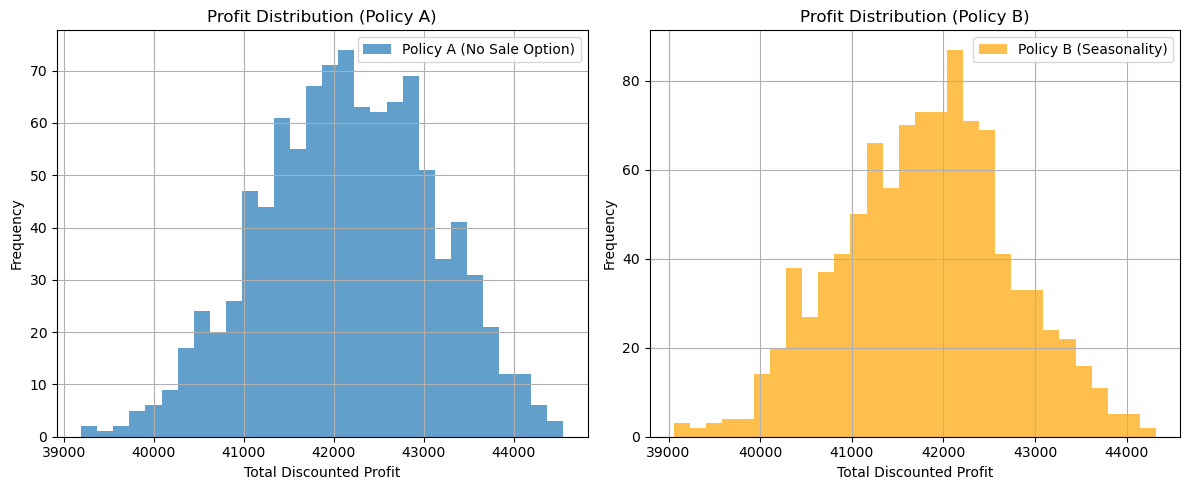

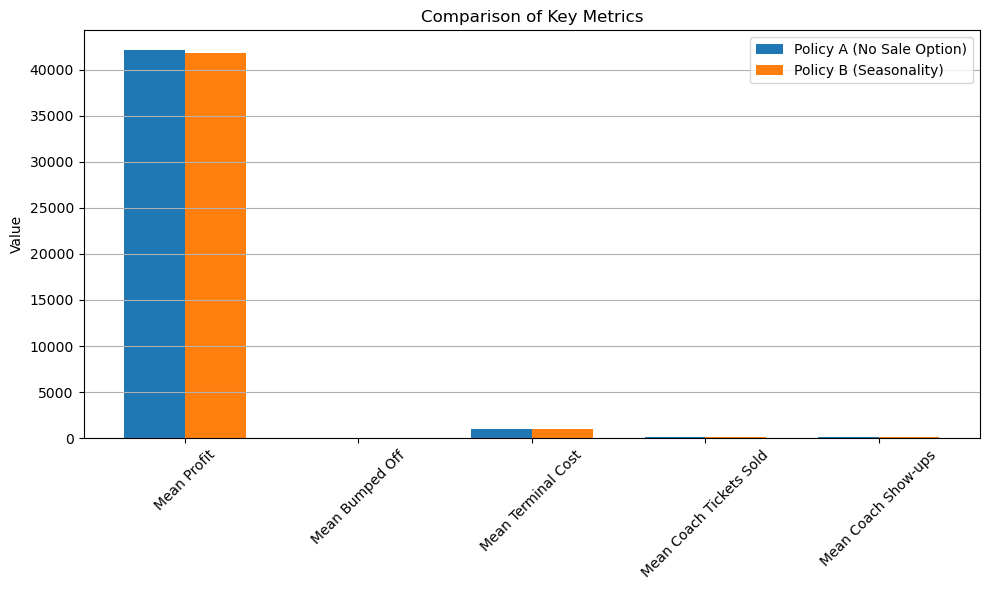

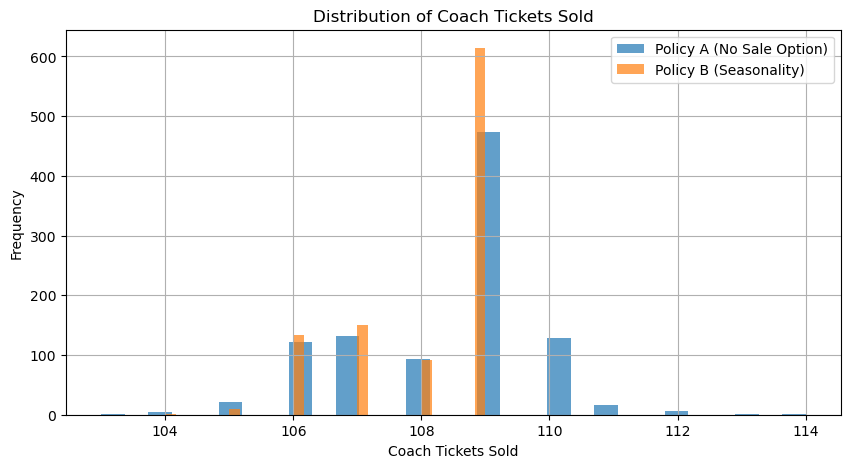

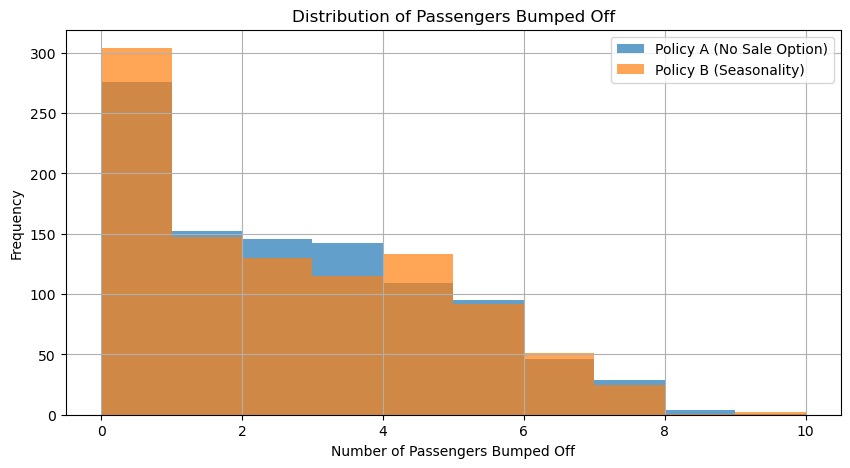

In [3]:

# ---------------------------
# 3) Evaluate New Policy with 'No Sale' Option (max 120 coach seats)
# ---------------------------
print("\nPART 3")
print("Solving DP for new policy with no sale option (max 120 coach seats)")
# Evaluate fixed overbooking policies (no "no sale" option) from 0 oversold to 20 oversold.
overbooking_values_no_sale = np.arange(0, 21)  # from 0 to 20 extra coach tickets allowed
profits_no_sale = []

print("Evaluating Fixed Overbooking Policies (no 'no sale' option):")
for overbook_amount in overbooking_values_no_sale:
    value_matrix_no_sale, policy_matrix_no_sale, profit_no_sale = solve_dynamic_programming(overbooking_allowance=overbook_amount, allow_no_sale=True)
    profits_no_sale.append(profit_no_sale)
    print(f"  Overbooking = {overbook_amount:2d} extra seats, Expected discounted profit: ${profit_no_sale:10.2f}")


# Find the best overbooking level
best_index_no_sale = np.argmax(profits_no_sale)
best_overbooking_no_sale = overbooking_values_no_sale[best_index_no_sale]
print("\nBest 'no sale' policy: Overbook coach by", best_overbooking_no_sale, "seats with expected profit of ${:.2f}".format(profits_no_sale[best_index_no_sale]))

plt.figure(figsize=(8,5))
plt.plot(overbooking_values_no_sale, profits_no_sale, marker='o')
plt.xlabel("'No Sale Policy' Coach Overbooking Allowance (extra tickets)")
plt.ylabel("Expected Discounted Profit")
plt.title("Overbooking 'No Sale Policy' vs Expected Discounted Profit")
plt.grid(True)
plt.show()

# Compare the two policies.
print("\nComparison:")
if best_overbooking_no_sale > best_overbooking:
    print(f"  The 'no sale' option policy performs BETTER by ${best_overbooking_no_sale - best_overbooking:.2f}")
else:
    print(f"  The best fixed overbooking policy performs BETTER by ${best_overbooking - best_overbooking_no_sale:.2f}")

# ---------------------------
# 4) Evaluate the Policy with Seasonality
# ---------------------------
print("\nPART 4")
print("Solving DP with seasonality factor (demand increases as departure nears)")
# Evaluate fixed overbooking policies (no "no sale" option) from 0 oversold to 20 oversold.
overbooking_values_seasonality = np.arange(0, 21)  # from 0 to 20 extra coach tickets allowed
profits_seasonality = []

print("Evaluating Fixed Overbooking Policies (no 'no sale' option):")
for overbook_amount in overbooking_values_seasonality:
    value_matrix_seasonality, policy_matrix_seasonality, profit_seasonality = solve_dynamic_programming(overbooking_allowance=overbook_amount, use_seasonality=True)
    profits_seasonality.append(profit_seasonality)
    print(f"  Overbooking = {overbook_amount:2d} extra seats, Expected discounted profit: ${profit_seasonality:10.2f}")

# Find the best overbooking level
best_index_seasonality = np.argmax(profits_seasonality)
best_overbooking_seasonality = overbooking_values_seasonality[best_index_seasonality]
print("\nBest 'Seasonality' policy: Overbook coach by", best_overbooking_seasonality, "seats with expected profit of ${:.2f}".format(profits_seasonality[best_index_seasonality]))

plt.figure(figsize=(8,5))
plt.plot(overbooking_values_seasonality, profits_seasonality, marker='o')
plt.xlabel("'Seasonality Policy' Coach Overbooking Allowance (extra tickets)")
plt.ylabel("Expected Discounted Profit")
plt.title("Overbooking 'Seasonality Policy' vs Expected Discounted Profit")
plt.grid(True)
plt.show()

# Compare the two policies.
print("\nComparison:")
# Find the best overbooking level
best_idx_no_sale = np.argmax(profits_no_sale)
if profits_seasonality[best_index_seasonality]> profits_no_sale[best_idx_no_sale]:
    print(f"The 'seasonality' policy performs BETTER by ${profits_seasonality[best_index_seasonality]- profits_no_sale[best_idx_no_sale]:.2f}")
else:
    print(f"'No Sale' policy performs BETTER by ${profits_no_sale[best_idx_no_sale] - profits_seasonality[best_index_seasonality]:.2f}")

# ================================
# PART 5: Forward Simulation and Analysis
# ================================
print("\nPART 5")
# Set number of simulation runs.
NUM_SIMULATIONS = 1000

# ---------------------------
# Policy A: Best 'No Sale Option' Policy (from Part 3)
# ---------------------------
# Use the best overbooking level from Part 3 (no sale option)
value_matrix_A, policy_matrix_A, profit_A = solve_dynamic_programming(overbooking_allowance=best_overbooking_no_sale, allow_no_sale=True, use_seasonality=False)
allowed_coach_tickets_A = COACH_SEAT_CAPACITY + best_overbooking_no_sale
allowed_first_class_tickets_A = FIRST_CLASS_SEAT_CAPACITY
results_A = simulate_policy(policy_matrix_A, allowed_coach_tickets_A, allowed_first_class_tickets_A, TOTAL_DAYS_UNTIL_FLIGHT, DAILY_DISCOUNT_RATE,
                            num_simulations=NUM_SIMULATIONS, allow_no_sale=True, use_seasonality=False)

# ---------------------------
# Policy B: Best Seasonality Policy (from Part 4)
# ---------------------------
# Use the best overbooking level from Part 4 (seasonality)
value_matrix_B, policy_matrix_B, profit_B = solve_dynamic_programming(overbooking_allowance=best_overbooking_seasonality, allow_no_sale=False, use_seasonality=True)
allowed_coach_tickets_B = COACH_SEAT_CAPACITY + best_overbooking_seasonality
allowed_first_class_tickets_B = FIRST_CLASS_SEAT_CAPACITY
results_B = simulate_policy(policy_matrix_B, allowed_coach_tickets_B, allowed_first_class_tickets_B, TOTAL_DAYS_UNTIL_FLIGHT, DAILY_DISCOUNT_RATE,
                            num_simulations=NUM_SIMULATIONS, allow_no_sale=False, use_seasonality=True)

# Process the simulation results into DataFrames.
results_df_A = pd.DataFrame(results_A)
results_df_B = pd.DataFrame(results_B)

def print_simulation_summary(results_dataframe, label):
    print(f"Summary for {label}:")
    print("Mean Total Profit: {:.2f}".format(results_dataframe['total_profit'].mean()))
    print("Profit Volatility (Std): {:.2f}".format(results_dataframe['total_profit'].std()))
    print("Overbook Frequency: {:.2%}".format(results_dataframe['overbooked'].mean()))
    print("Average Number Bumped Off: {:.2f}".format(results_dataframe['bumped_off'].mean()))
    print("Average Terminal Cost: {:.2f}".format(results_dataframe['terminal_cost'].mean()))
    print("Average Coach Tickets Sold: {:.2f}".format(results_dataframe['coach_sold'].mean()))
    print("Average FC Tickets Sold: {:.2f}".format(results_dataframe['fc_sold'].mean()))
    print("Average Coach Show-ups: {:.2f}".format(results_dataframe['coach_show'].mean()))
    print("Average FC Show-ups: {:.2f}".format(results_dataframe['fc_show'].mean()))
    print("\n")

print_simulation_summary(results_df_A, "Policy A (No Sale Option)")
print_simulation_summary(results_df_B, "Policy B (Seasonality)")

# Plot histogram of total discounted profits for both policies.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(results_df_A["total_profit"], bins=30, alpha=0.7, label="Policy A (No Sale Option)")
plt.xlabel("Total Discounted Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution (Policy A)")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.hist(results_df_B["total_profit"], bins=30, alpha=0.7, color="orange", label="Policy B (Seasonality)")
plt.xlabel("Total Discounted Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution (Policy B)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart comparing key metrics between the two policies.
metrics = ['total_profit', 'bumped_off', 'terminal_cost', 'coach_sold', 'coach_show']
labels = ['Mean Profit', 'Mean Bumped Off', 'Mean Terminal Cost', 'Mean Coach Tickets Sold', 'Mean Coach Show-ups']
values_A = [results_df_A[metric].mean() for metric in metrics]
values_B = [results_df_B[metric].mean() for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, values_A, width, label="Policy A (No Sale Option)")
plt.bar(x + width/2, values_B, width, label="Policy B (Seasonality)")
plt.xticks(x, labels, rotation=45)
plt.ylabel("Value")
plt.title("Comparison of Key Metrics")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Additional plots: Distribution of coach tickets sold.
plt.figure(figsize=(10,5))
plt.hist(results_df_A["coach_sold"], bins=30, alpha=0.7, label="Policy A (No Sale Option)")
plt.hist(results_df_B["coach_sold"], bins=30, alpha=0.7, label="Policy B (Seasonality)")
plt.xlabel("Coach Tickets Sold")
plt.ylabel("Frequency")
plt.title("Distribution of Coach Tickets Sold")
plt.legend()
plt.grid(True)
plt.show()

# Additional plots: Distribution of passengers bumped off.
plt.figure(figsize=(10,5))
plt.hist(results_df_A["bumped_off"], bins=range(0, int(results_df_A["bumped_off"].max())+2), alpha=0.7, label="Policy A (No Sale Option)")
plt.hist(results_df_B["bumped_off"], bins=range(0, int(results_df_B["bumped_off"].max())+2), alpha=0.7, label="Policy B (Seasonality)")
plt.xlabel("Number of Passengers Bumped Off")
plt.ylabel("Frequency")
plt.title("Distribution of Passengers Bumped Off")
plt.legend()
plt.grid(True)
plt.show()

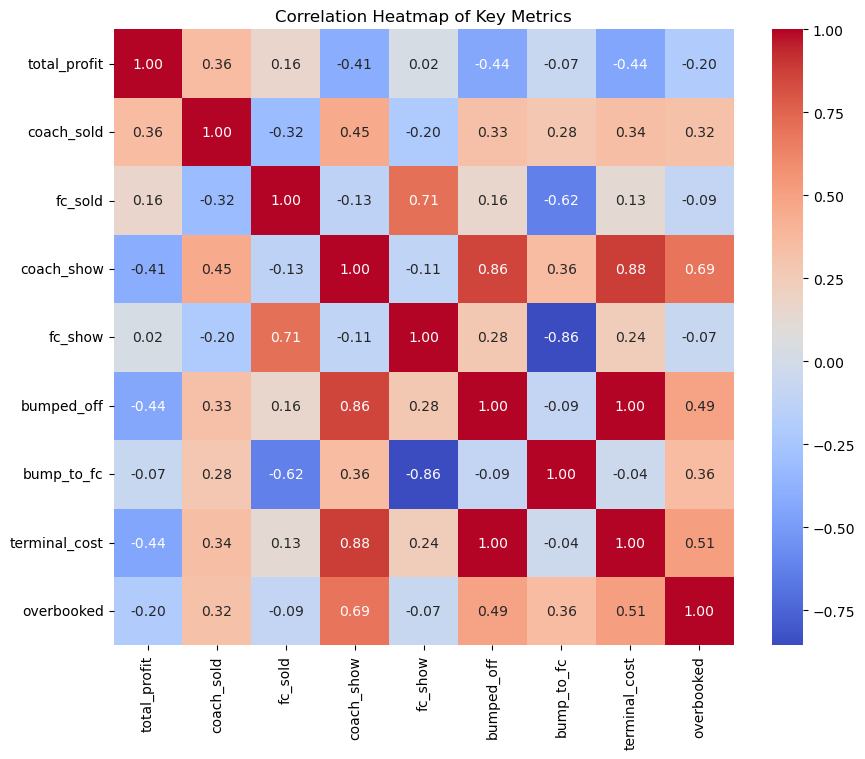

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add a column for policy type
results_df_A["Policy"] = "Policy A"
results_df_B["Policy"] = "Policy B"

# Combine both into one DataFrame
combined_df = pd.concat([results_df_A, results_df_B], ignore_index=True)

# Drop non-numeric columns for correlation
correlation_matrix = combined_df.drop(columns=["Policy"]).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Key Metrics")
plt.show()

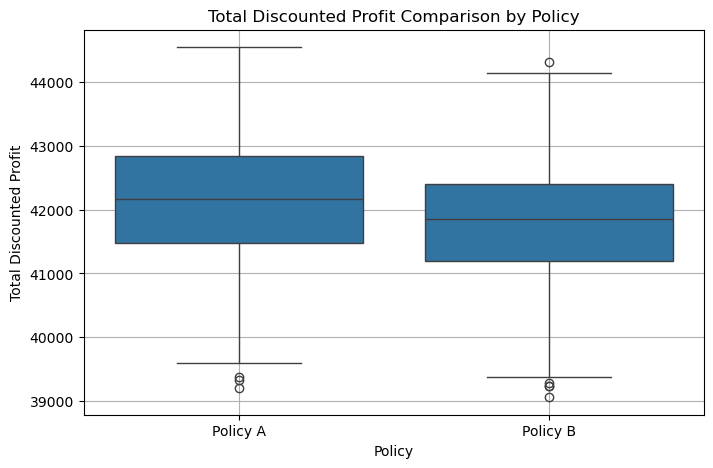

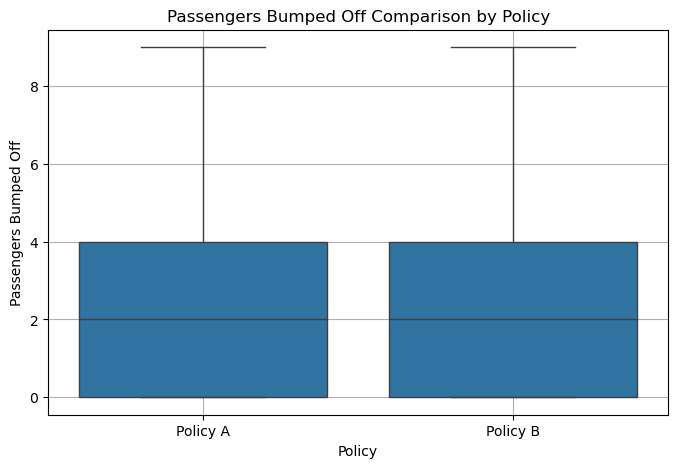

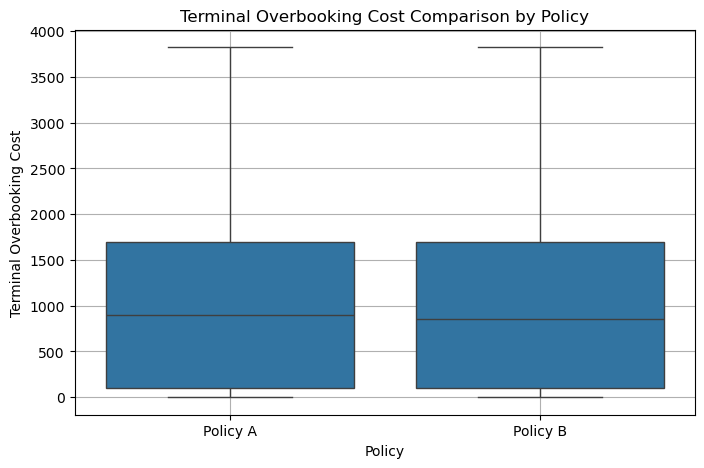

In [5]:
# Boxplot comparison (Profit, Bumped Passengers, Terminal Cost)
metrics = {
    "total_profit": "Total Discounted Profit",
    "bumped_off": "Passengers Bumped Off",
    "terminal_cost": "Terminal Overbooking Cost"
}

for col, label in metrics.items():
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=combined_df, x="Policy", y=col)
    plt.title(f"{label} Comparison by Policy")
    plt.ylabel(label)
    plt.grid(True)
    plt.show()